## Assignment 4: Obsevational Studies and Applied ML

### Deadline
November 21st,11:59PM

### Important notes

Make sure you push on GitHub your notebook with all the cells already evaluated. Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you implemented. Back up any hypotheses and claims with data, since this is an important aspect of the course. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a single notebook (plus the data files necessary) in the master branch. If there are multiple notebooks present, we will not grade anything.

Use this legendary link to create your repository: [link](https://classroom.github.com/g/YXtsr0QK)

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from math import sqrt

import seaborn as sns
%matplotlib inline

In [2]:
data_folder = './data/'

## Task 1: Boosting the economy by incentivizing self-employment

Assume the biggest priority of the local government in 2018 is to increase per-capita income. To do so, the officials plan to adopt a strategy for incentivizing self-employment through a series of campaigns, educational programs, and dedicated funds.

Since it is unethical and impossible in this setting to run a controlled experiment involving citizens (e.g., fire employees and force them to self-employ), the officials have asked you, the data scientist, to establish the effect of self-employment on the economy, relying on observational data.

**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.

**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

Hint: It is useful to add a notion of confidence to your results and explore the data visually. You are allowed to use the SciPy library.

___
**A)** You will be working with the full US 2015 census dataset (acs2015_county_data.csv, available at https://www.kaggle.com/muonneutrino/us-census-demographic-data#acs2015_county_data.csv). Using suitable methods, determine and quantify the dependency between the percentage of self-employed citizens and per capita income across all 3,212 US counties. Do citizens in counties that have a higher percentage of self-employed people earn more per capita?

In [3]:
county_data = pd.read_csv(data_folder+'acs2015_county_data.csv')

In [4]:
county_self_employed_income = county_data[['SelfEmployed','IncomePerCap']]

Pearson coefficient between per capita income and the percentage of self-employed citizens: 0.0873


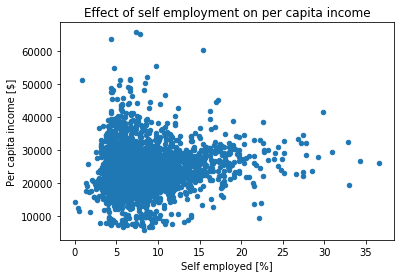

In [5]:
county_self_employed_income.plot.scatter(x='SelfEmployed', y='IncomePerCap' )
plt.xlabel('Self employed [%]')
plt.ylabel('Per capita income [$]')
plt.title('Effect of self employment on per capita income')
print("Pearson coefficient between per capita income and the percentage of self-employed " +
      "citizens: %.4f" % county_self_employed_income.corr()['IncomePerCap'][0])

Visual inspection and the correlation coefficient do not indicate that there is a dependance between the percentage of self-employed people and per capita income. However, we will still perform a linear regression and a bilateral statistical test on the slope: $H_0: \beta=0$ vs $H_1: \beta\neq0$.<br>
$\beta$ is asymptotically normal with $\sigma_\beta^2 = \frac{\sigma^2}{SSQ}$ where $SSQ$ is the sum of squares.
<a href="https://en.wikipedia.org/wiki/Simple_linear_regression">Source</a>

In [6]:
def linreg_confidence_interval(X,y):
    # create the model
    linreg = LinearRegression()
    linreg.fit(X,y)
    #build the confidence interval for beta
    pred = linreg.predict(X)
    epsilon = y-pred
    std_error= sum(epsilon**2)/(y.shape[0]-2)
    x_bar = X.mean()[0]
    denominator = sum((X.SelfEmployed-x_bar)**2)
    s_beta = sqrt(std_error/denominator)
    beta_conf_95perc = [linreg.coef_[0]-s_beta*1.96,linreg.coef_[0]+s_beta*1.96]
    return beta_conf_95perc

In [7]:
def linreg_plot_best_fit(X,y):
    # fit and predict
    linreg = LinearRegression()
    linreg.fit(X,y)
    pred = linreg.predict(X)
    # plot
    plt.scatter(X,y)
    plt.plot(X,pred,'r')
    plt.title('SelfEmployment-Income fit')
    plt.xlabel('Self employed [%]')
    plt.ylabel('Per capita income [$]')
    
    # Print the results (the increase/decrease)
    increase = linreg.coef_[0]*10
    to_print = 'Effect of increasing self employment by 10 percentage points: '
    if(increase > 0):
        to_print += '+'
    print(to_print + '%.2f' % increase)

In [8]:
def display_confidence_interval(confidence_interval_to_display):
    """
    Return a nicer form to display confidence intervals with 2 digits
    """
    return "[%.2f" % confidence_interval_to_display[0] + ", %.2f"% confidence_interval_to_display[1]+"]"

In [9]:
# fit the linear model
X = county_self_employed_income[['SelfEmployed']]
y = county_self_employed_income.IncomePerCap

us_beta_conf = linreg_confidence_interval(X,y)
print("Confidence interval for beta for US: " + display_confidence_interval(us_beta_conf))

Confidence interval for beta for US: [83.76, 192.86]


In [10]:
x_bar = X.mean()[0]
denominator = sum((X.SelfEmployed-x_bar)**2)
denominator

49337.68355279477

Effect of increasing self employment by 10 percentage points: +1383.09


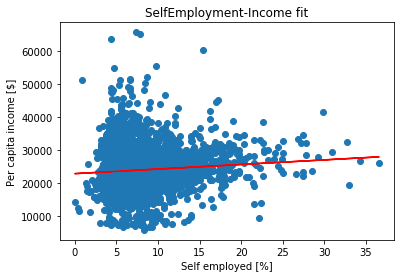

In [11]:
linreg_plot_best_fit(X,y)

From the statistical test, we can conclude that there is indeed a positive effect of self-employment on per capita income. However, the plot shows that the effect in only minor. We can only increase the per capita income by 13'000$ if we increase the self-employment by 10 percentage point which is very difficult (assuming the relationship between the two variables is causal, which is not sure).

___
**B)** The pilot program will involve all counties within a limited set of three US states. Set A includes Wisconsin, Tennessee, and  Minnesota. Quantify the dependency of per-capita income on self-employment rates across all the counties in set A.<br>
We can now use the funcions defined before after filtering the dataframe.

In [12]:
group_A_states = ['Wisconsin','Tennessee', 'Minnesota']
group_A = county_data[county_data.State.isin(group_A_states)]

group_A_beta_conf = linreg_confidence_interval(group_A[['SelfEmployed']],group_A.IncomePerCap)
print('Confidence interval for beta for group A: ' + display_confidence_interval(group_A_beta_conf))


Confidence interval for beta for group A: [-571.06, -143.78]


Effect of increasing self employment by 10 percentage points: -3574.21


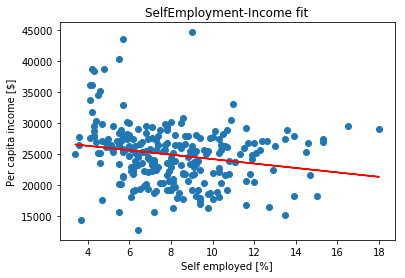

In [13]:
linreg_plot_best_fit(group_A[['SelfEmployed']],group_A.IncomePerCap)

We see that for group A, the slope is negative and the confidence interval does not inclue 0. So in group A, supporting self-employment would in fact be bad!

___
**C)** In which state within set A is the observed effect of self-employment on per-capita income the strongest?

In [14]:
wisconsin = county_data[county_data.State=='Wisconsin']

wisconsin_beta_conf = linreg_confidence_interval(wisconsin[['SelfEmployed']],wisconsin.IncomePerCap)
print('Confidence interval for beta for Wisconsin: ' + display_confidence_interval(wisconsin_beta_conf))

Confidence interval for beta for Wisconsin: [-827.20, -162.10]


In [15]:
tennessee = county_data[county_data.State=='Tennessee']

tennessee_beta_conf = linreg_confidence_interval(tennessee[['SelfEmployed']],tennessee.IncomePerCap)
print('Confidence interval for beta for Tennessee: ' + display_confidence_interval(tennessee_beta_conf))

Confidence interval for beta for Tennessee: [-870.33, -81.84]


In [16]:
minnesota = county_data[county_data.State=='Minnesota']

minnesota_beta_conf = linreg_confidence_interval(minnesota[['SelfEmployed']],minnesota.IncomePerCap)
print('Confidence interval for beta for Wisconsin: ' + display_confidence_interval(minnesota_beta_conf))

Confidence interval for beta for Wisconsin: [-516.03, -54.16]


When looking at these confidence intervals, we see that Tennessee and Wisconsin have a similar effect of self-employment on income per capita. Minnesota has a effect that is less bad.

___
**D)** Set B includes New Jersey, Kansas, and Rhode Island. Repeat the analysis from steps B and C above, but now for set B. In which of the two sets A and B (if any) would you recommend incentivizing self-employment? Explain your reasoning.

In [17]:
group_B_states = ['New Jersey', 'Kansas', 'Rhode Island']
group_B = county_data[county_data.State.isin(group_B_states)]

group_B_beta_conf = linreg_confidence_interval(group_B[['SelfEmployed']],group_B.IncomePerCap)
print('Confidence interval for beta for group B: ' + display_confidence_interval(group_A_beta_conf))

Confidence interval for beta for group B: [-571.06, -143.78]


Effect of increasing self employment by 10 percentage points: -3099.97


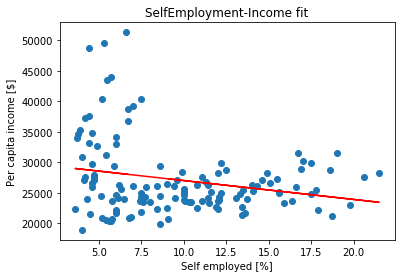

In [18]:
linreg_plot_best_fit(group_B[['SelfEmployed']],group_B.IncomePerCap)

In [19]:
new_jersey = county_data[county_data.State=='New Jersey']

new_jersey_beta_conf = linreg_confidence_interval(new_jersey[['SelfEmployed']],new_jersey.IncomePerCap)
print('Confidence interval for beta for New Jersey: ' + display_confidence_interval(new_jersey_beta_conf))

Confidence interval for beta for New Jersey: [692.37, 7035.50]


In [20]:
kansas = county_data[county_data.State=='Kansas']

kansas_beta_conf = linreg_confidence_interval(kansas[['SelfEmployed']],kansas.IncomePerCap)
print('Confidence interval for beta for Kansas: ' + display_confidence_interval(kansas_beta_conf))

Confidence interval for beta for Kansas: [50.04, 311.11]


In [21]:
rhode_island = county_data[county_data.State=='Rhode Island']

rhode_island_beta_conf = linreg_confidence_interval(rhode_island[['SelfEmployed']],rhode_island.IncomePerCap)
print('Confidence interval for beta for Rhode Island: ' + display_confidence_interval(rhode_island_beta_conf))

Confidence interval for beta for Rhode Island: [1413.97, 4747.91]


We would incentivise self-employment in group B. While overall, self-employment seems to have a negative effect on income, it is positive for each city. This is a 'paradoxon' that we have seen in class. The populations of the states are alligned in the space such that the overall slope in a group is negative while all slopes in states are positive. However, we will stay in a state and increase the self-employment percentage there. So we care about the slope in the state and not the group. So implementing the policy in group B would be advisable, if we can choose the state, we would chose Rhode island.
<br>
<br>
Below, we give the reason why the overall slope is negative while in each state the slope is positive: <br>
The counties have different ranges for self-employment percentage and income per capita.

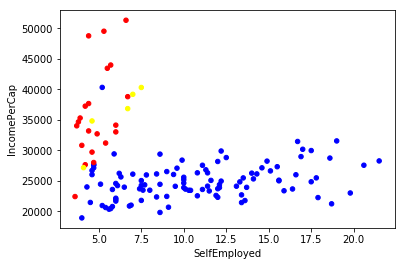

In [22]:
group_B = group_B[['SelfEmployed','IncomePerCap','State']]
cmap = {'New Jersey': 'red', 'Kansas': 'blue', 'Rhode Island': 'yellow'}
group_B.plot(x='SelfEmployed', y='IncomePerCap', kind='scatter', 
        c=[cmap.get(c, 'black') for c in group_B.State])
plt.show()

## Task 2: All you need is love… And a dog!

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

You are allowed to use the scikit-learn library to implement your classifiers.

___
**A)** Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. Standardize the values of each feature in the data to have mean 0 and variance 1. The use of external libraries is not permitted in part A, except for numpy and pandas.

In [23]:
shelter_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv')

In [24]:
# List of usefull features, and the prediction column
shelter_features= ['animal_type','intake_year','intake_condition','intake_number', 'intake_type','sex_upon_intake','age_upon_intake_(years)','time_in_shelter_days','sex_upon_outcome','age_upon_outcome_(years)',]
shelter_output = ['outcome_type']

In [25]:
# Extract the features from the data, using dummy-encooding
x = pd.get_dummies(shelter_data[shelter_features])
x.head()

intake_year  intake_number  age_upon_intake_(years)  time_in_shelter_days  \
0         2017            1.0                     10.0              0.588194   
1         2014            2.0                      7.0              1.259722   
2         2014            3.0                      6.0              1.113889   
3         2014            1.0                     10.0              4.970139   
4         2013            1.0                     16.0              0.119444   

   age_upon_outcome_(years)  animal_type_Bird  animal_type_Cat  \
0                      10.0                 0                0   
1                       7.0                 0                0   
2                       6.0                 0                0   
3                      10.0                 0                0   
4                      16.0                 0                0   

   animal_type_Dog  animal_type_Other  intake_condition_Aged  \
0                1                  0                      0   
1                1                  0                      0   
2                1                  0                      0   
3                1                  0                      0   
4                1                  0                      0   

             ...             sex_upon_intake_Intact Female  \
0            ...                                         0   
1            ...                                         0   
2            ...                                         0   
3            ...                                         0   
4            ...                                         0   

   sex_upon_intake_Intact Male  sex_upon_intake_Neutered Male  \
0                            0                              1   
1                            0                              1   
2                            0                              1   
3                            0                              1   
4                            0                              1   

   sex_upon_intake_Spayed Female  sex_upon_intake_Unknown  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   sex_upon_outcome_Intact Female  sex_upon_outcome_Intact Male  \
0                               0                             0   
1                               0                             0   
2                               0                             0   
3                               0                             0   
4                               0                             0   

   sex_upon_outcome_Neutered Male  sex_upon_outcome_Spayed Female  \
0                               1                               0   
1                               1                               0   
2                               1                               0   
3                               1                               0   
4                               1                               0   

   sex_upon_outcome_Unknown  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 32 columns]

In [26]:
# Get the predicted values (in the form of a series)
y = pd.get_dummies(shelter_data[shelter_output])['outcome_type_Adoption']

In [27]:
# Split the data into train and test set
train_x=x.sample(frac=0.8,random_state=200)
index = train_x.index

train_x = train_x.reset_index(drop=True)
test_x = x.drop(index).reset_index(drop=True)
train_y = y[index].reset_index(drop=True)
test_y = y.drop(index).reset_index(drop=True)

In [28]:
# Standardize the data
test_x = (test_x-test_x.mean()) / test_x.std()
train_x = (train_x-train_x.mean()) / train_x.std()

In [29]:
# Check that the data is normalized
test_x.describe(percentiles=[])

intake_year  intake_number  age_upon_intake_(years)  \
count  1.593400e+04   1.593400e+04             1.593400e+04   
mean   1.723178e-13  -3.014053e-15             2.743692e-14   
std    1.000000e+00   1.000000e+00             1.000000e+00   
min   -1.877066e+00  -2.860443e-01            -7.276115e-01   
50%   -3.362696e-01  -2.860443e-01            -3.828430e-01   
max    1.974925e+00   1.550060e+01             6.167758e+00   

       time_in_shelter_days  age_upon_outcome_(years)  animal_type_Bird  \
count          1.593400e+04              1.593400e+04      1.593400e+04   
mean           6.965789e-16             -3.098622e-15     -2.462138e-15   
std            1.000000e+00              1.000000e+00      1.000000e+00   
min           -3.929039e-01             -7.373125e-01     -6.497950e-02   
50%           -2.759003e-01             -3.933312e-01     -6.497950e-02   
max            3.435244e+01              6.142313e+00      1.538850e+01   

       animal_type_Cat  animal_type_Dog  animal_type_Other  \
count     1.593400e+04     1.593400e+04       1.593400e+04   
mean     -7.836172e-15     7.293219e-15       1.977917e-15   
std       1.000000e+00     1.000000e+00       1.000000e+00   
min      -7.567068e-01    -1.163863e+00      -2.443759e-01   
50%      -7.567068e-01     8.591537e-01      -2.443759e-01   
max       1.321433e+00     8.591537e-01       4.091800e+00   

       intake_condition_Aged            ...             \
count           1.593400e+04            ...              
mean            4.995404e-15            ...              
std             1.000000e+00            ...              
min            -6.300202e-02            ...              
50%            -6.300202e-02            ...              
max             1.587151e+01            ...              

       sex_upon_intake_Intact Female  sex_upon_intake_Intact Male  \
count                   1.593400e+04                 1.593400e+04   
mean                    8.413420e-15                -7.830229e-17   
std                     1.000000e+00                 1.000000e+00   
min                    -6.546136e-01                -6.773932e-01   
50%                    -6.546136e-01                -6.773932e-01   
max                     1.527523e+00                 1.476155e+00   

       sex_upon_intake_Neutered Male  sex_upon_intake_Spayed Female  \
count                   1.593400e+04                   1.593400e+04   
mean                    2.624179e-15                  -1.329278e-14   
std                     1.000000e+00                   1.000000e+00   
min                    -4.339292e-01                  -4.035910e-01   
50%                    -4.339292e-01                  -4.035910e-01   
max                     2.304379e+00                   2.477600e+00   

       sex_upon_intake_Unknown  sex_upon_outcome_Intact Female  \
count             1.593400e+04                    1.593400e+04   
mean             -9.517177e-15                    4.342809e-15   
std               1.000000e+00                    1.000000e+00   
min              -3.085281e-01                   -3.601976e-01   
50%              -3.085281e-01                   -3.601976e-01   
max               3.240993e+00                    2.776080e+00   

       sex_upon_outcome_Intact Male  sex_upon_outcome_Neutered Male  \
count                  1.593400e+04                    1.593400e+04   
mean                   7.079236e-15                   -6.511799e-15   
std                    1.000000e+00                    1.000000e+00   
min                   -3.721014e-01                   -7.360145e-01   
50%                   -3.721014e-01                   -7.360145e-01   
max                    2.687271e+00                    1.358584e+00   

       sex_upon_outcome_Spayed Female  sex_upon_outcome_Unknown  
count                    1.593400e+04              1.593400e+04  
mean                    -1.357922e-15             -9.517177e-15  
std                      1.000000e+00              1.0000

In [30]:
train_x.describe(percentiles=[])

intake_year  intake_number  age_upon_intake_(years)  \
count  6.373800e+04   6.373800e+04             6.373800e+04   
mean  -7.765261e-14   2.433905e-15             1.362351e-13   
std    1.000000e+00   1.000000e+00             1.000000e+00   
min   -1.867463e+00  -2.761872e-01            -7.287642e-01   
50%   -3.342445e-01  -2.761872e-01            -3.829068e-01   
max    1.965584e+00   2.585810e+01             7.917672e+00   

       time_in_shelter_days  age_upon_outcome_(years)  animal_type_Bird  \
count          6.373800e+04              6.373800e+04      6.373800e+04   
mean           3.403666e-15              1.742435e-13     -1.032184e-16   
std            1.000000e+00              1.000000e+00      1.000000e+00   
min           -4.044139e-01             -7.391741e-01     -6.546520e-02   
50%           -2.840609e-01             -3.941483e-01     -6.546520e-02   
max            3.833569e+01              7.886470e+00      1.527505e+01   

       animal_type_Cat  animal_type_Dog  animal_type_Other  \
count     6.373800e+04     6.373800e+04       6.373800e+04   
mean     -1.639921e-16     9.847398e-16       9.269538e-16   
std       1.000000e+00     1.000000e+00       1.000000e+00   
min      -7.703252e-01    -1.146491e+00      -2.421346e-01   
50%      -7.703252e-01     8.722127e-01      -2.421346e-01   
max       1.298133e+00     8.722127e-01       4.129870e+00   

       intake_condition_Aged            ...             \
count           6.373800e+04            ...              
mean           -3.214135e-16            ...              
std             1.000000e+00            ...              
min            -6.350257e-02            ...              
50%            -6.350257e-02            ...              
max             1.574715e+01            ...              

       sex_upon_intake_Intact Female  sex_upon_intake_Intact Male  \
count                   6.373800e+04                 6.373800e+04   
mean                    2.065522e-15                -2.646685e-15   
std                     1.000000e+00                 1.000000e+00   
min                    -6.498247e-01                -6.837356e-01   
50%                    -6.498247e-01                -6.837356e-01   
max                     1.538852e+00                 1.462531e+00   

       sex_upon_intake_Neutered Male  sex_upon_intake_Spayed Female  \
count                   6.373800e+04                   6.373800e+04   
mean                   -6.196820e-17                   1.504762e-15   
std                     1.000000e+00                   1.000000e+00   
min                    -4.360482e-01                  -4.034091e-01   
50%                    -4.360482e-01                  -4.034091e-01   
max                     2.293289e+00                   2.478834e+00   

       sex_upon_intake_Unknown  sex_upon_outcome_Intact Female  \
count             6.373800e+04                    6.373800e+04   
mean             -1.734533e-15                    2.030175e-15   
std               1.000000e+00                    1.000000e+00   
min              -3.043641e-01                   -3.645772e-01   
50%              -3.043641e-01                   -3.645772e-01   
max               3.285487e+00                    2.742861e+00   

       sex_upon_outcome_Intact Male  sex_upon_outcome_Neutered Male  \
count                  6.373800e+04                    6.373800e+04   
mean                   1.089849e-15                   -3.895343e-16   
std                    1.000000e+00                    1.000000e+00   
min                   -3.732502e-01                   -7.435793e-01   
50%                   -3.732502e-01                   -7.435793e-01   
max                    2.679126e+00                    1.344825e+00   

       sex_upon_outcome_Spayed Female  sex_upon_outcome_Unknown  
count                    6.373800e+04              6.373800e+04  
mean                    -3.651310e-16             -1.734533e-15  
std                      1.000000e+00              1.0000

___
**B)** Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold. The shelter has a limited capacity and has no other option but to put to sleep animals with a low probability of adoption. What metric (precision, recall, accuracy, or F1-score) and with respect to what class is the most relevant when choosing the threshold in this scenario, and why? Explain your reasoning.

In [31]:
logistic = LogisticRegression()
logistic.fit(train_x,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
prob_prediction = logistic.predict_proba(test_x)
prob_prediction

array([[7.75141539e-01, 2.24858461e-01],
       [9.95521075e-01, 4.47892502e-03],
       [9.80359521e-01, 1.96404788e-02],
       ...,
       [9.86119442e-01, 1.38805579e-02],
       [9.86119258e-01, 1.38807415e-02],
       [9.99396752e-01, 6.03247512e-04]])

In [33]:
threshold = 0.5
def pred_with_threshold(prob_prediction, threshold = 0.5):
    """
    From an array of probabilistic predictions (between 0 and 1), return an array of 
    predictions (0 or 1) depending of the probability being below or above the threshold
    """
    prediction = (prob_prediction[:,0] < threshold).astype(int)
    return prediction


In [34]:
# Check that our function pred_with_threshold with a threshold of 0.5 actually works by comparing it to the built in predict function
sum(abs(pred_with_threshold(prob_prediction, threshold) - logistic.predict(test_x)))

0

We create some helper functions

In [35]:
def create_confusion_matrix(prediction, y, show = False):
    """
    Create the 2x2 confusion matrix based on a prediction and the true values for a binary classifier
    
    Parameters
    ----------
    prediction : ndarray = The prediction vector
    y : ndarray          = The true values vector
    show : Bool          = Set to true to print the confusion matrix
    
    Returns
    ----------
    list = A list containing the true positive count, the true negative count, the false positive count and the false negative count
    """
    true_pos, true_neg, false_pos, false_neg = (0, 0, 0, 0)
    for i in range(len(prediction)):
        if prediction[i] == 1 and y[i] == 1:
             true_pos += 1
        if prediction[i] == 1 and y[i] == 0:
             false_pos += 1
        if prediction[i] == 0 and y[i] == 1:
             false_neg += 1
        if prediction[i] == 0 and y[i] == 0:
             true_neg += 1
    if show:
        print("Confusion Matrix with threshold " + str(threshold) + " : \n")
        print("True value \ Prediction | Adopted | Not Adopted")
        print("------------------------|---------|------------")
        print("        Adopted         |  " + str(true_pos)  + "   |    " + str(false_neg))
        print("      Not Adopted       |  " + str(false_pos) + "   |    " + str(true_neg))
    
    return [true_pos, true_neg, false_pos, false_neg]

In [36]:
def get_metrics(conf_matrix, show = False):
    """
    Given a classification matrix for a binary classifier, compute the accuracy, the precision, the recall
    and the F1 score, with respect to both the positive and negativee class
    
    Parameters
    ----------
    conf_matrix : list = List of 4 elements corresponding to a 2x2 confusion matrix
    show : Bool          = Set to true to print the confusion matrix
    
    Returns
    ----------
    
    The accuracy, the precision, the recall
    and the F1 score, with respect to both the positive and negative class
    """
    accuracy = (conf_matrix[0] + conf_matrix[1]) / sum(conf_matrix)
    
    precision_pos = 0
    precision_neg = 0
    
    if (conf_matrix[0] + conf_matrix[2] != 0):
        precision_pos = conf_matrix[0] / (conf_matrix[0] + conf_matrix[2])
    
    if (conf_matrix[1] + conf_matrix[3] != 0):
        precision_neg = conf_matrix[1] / (conf_matrix[1] + conf_matrix[3])
        
    recall_pos = 0
    recall_neg = 0
    
    if (conf_matrix[0] + conf_matrix[3] != 0):
        recall_pos = conf_matrix[0] / (conf_matrix[0] + conf_matrix[3]) 
    
    if (conf_matrix[1] + conf_matrix[2] != 0):
        recall_neg = conf_matrix[1] / (conf_matrix[1] + conf_matrix[2]) 
        
    f1_pos = 0
    f1_neg = 0
    
    if (precision_pos+recall_pos != 0):
        f1_pos = 2*(precision_pos*recall_pos)/(precision_pos+recall_pos)
    
    if (precision_neg+recall_neg != 0):
        f1_neg = 2*(precision_neg*recall_neg)/(precision_neg+recall_neg)
        
    if show:
        print("Accuracy : %s" % accuracy)
        print("Precision wrt Positive class : %s" % precision_pos)
        print("Precision wrt Negative class : %s" % precision_neg)
        print("Recall wrt Positive class : %s" % recall_pos)
        print("Recall wrt Negative class : %s" % recall_neg)
        print("F1 wrt Positive class : %s" % f1_pos)
        print("F1 wrt Negative class : %s" % f1_neg)
        
    return accuracy, precision_pos, recall_pos, f1_pos, precision_neg, recall_neg, f1_neg

We show the metrics for our prediction using a threshold of 0.5

In [37]:
# Create the confusion for our prediction with a 0.5 threshold
conf_matrix = create_confusion_matrix(pred_with_threshold(prob_prediction), np.array(test_y))

In [38]:
# Show the metrics for our prediction
metrics = get_metrics(conf_matrix, show=True)

Accuracy : 0.8191289067403038
Precision wrt Positive class : 0.7744371416585093
Precision wrt Negative class : 0.8555163383809632
Recall wrt Positive class : 0.8135742617893346
Recall wrt Negative class : 0.8232716117015448
F1 wrt Positive class : 0.7935234274251325
F1 wrt Negative class : 0.8390843104410943


We will now vary the threshold and plot the results

In [39]:
thresholds = np.linspace(0.1, 0.99, 100)
# Make the prediction for all the thresholds
predictions = [pred_with_threshold(prob_prediction, x) for x in thresholds]

In [40]:
# Create the confusion matrices for our thresholds
conf_matrices = [create_confusion_matrix(x, test_y) for x in predictions]

In [41]:
# Compute the metrics for our thresholds
metrics = [get_metrics(x) for x in conf_matrices]
accuracies, precisions_adopted, recalls_adopted, f1s_adopted, precisions_not_adopted, recalls_not_adopted, f1s_not_adopted = zip(*metrics)

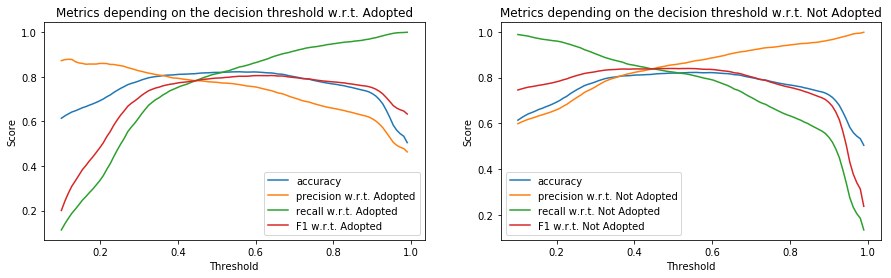

In [42]:
# Plot the results, with respect to the positive and the negative classe (Adopted vs Non Adopted)
ig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
ax1.plot(thresholds, accuracies, label='accuracy')
ax1.plot(thresholds, precisions_adopted, label='precision w.r.t. Adopted')
ax1.plot(thresholds, recalls_adopted, label='recall w.r.t. Adopted')
ax1.plot(thresholds, f1s_adopted, label='F1 w.r.t. Adopted')
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.set_title("Metrics depending on the decision threshold w.r.t. Adopted")
ax1.legend()

ax2.plot(thresholds, accuracies, label='accuracy')
ax2.plot(thresholds, precisions_not_adopted, label='precision w.r.t. Not Adopted')
ax2.plot(thresholds, recalls_not_adopted, label='recall w.r.t. Not Adopted')
ax2.plot(thresholds, f1s_not_adopted, label='F1 w.r.t. Not Adopted')
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Score")
ax2.set_title("Metrics depending on the decision threshold w.r.t. Not Adopted")
ax2.legend()

plt.show()

We want to find a balance between two cases :

>We don't want to put to sleep animals that have some chance of being adopted -> minimize the number of false negatives (predict it won't be adopted but it is actually adopted) => maximize the accuracy with respect to the Negative class 'Not Adopted'. By maximizing the accuracy w.r.t the negative class, we ensure that when we predict that an animal won't be adopted, it is very likely that our prediction is correct. We could also maximize the recall w.r.t the positive class 'Adopted', which would have a similar effect (Among the adopted animals, maximize for how many we did predict the adoption correctly)

>But since the shelter capacity is limited, we also don't want to keep too many animals that have a low chance of being adopted. -> minimize the number of false positive (Predict it will be adopted but is actually isn't) => maximize the accuracy w.r.t the positive class, we ensure that when we predict that an animal will be adopted, it is very likely that our prediction is correct. We could also maximize the recall w.r.t the negative class 'Not Adopted', which would have a similar effect (Among the non-adopted animals, maximize for how many we did predict the non-adoption correctly = minimize how many were kept alive).

We suppose that both these cases are as important, so we should try to maximize the F1-score wrt the positive and negative class (corresponding to a threshold of ~0.5). However, if one of those arguments is more important, we could use a weighted F1-score, and the threshold would vary depending on this weight (If the first case is more important, the threshold would be smaller than 0.5 (Adopt more animals), if the second case is more important, the threshold would be greater than 0.5).

___
**C)** Reduce the number of features by selecting the subset of the k best features. Use greedy backward selection to iteratively remove features. Evaluate performance and visualize the result using 5-fold cross-validation on the training set as a function of k, where k = 1, 5, 10, 15, 20, 25, 30. Choose the optimal k and justify your choice. Interpret the top-k features and their impact on the probability of adoption.

In [43]:
def build_k_indices(y, k_fold, seed=0):
    """
    Build k indices for k-fold.
    Function created for the Machine Learining course
    
    Parameters
    ----------
    y:        pd.Series = array of classifications, used to know the size of the dataset
    k_fold:   int       = Number of folds to perform
    seed:     int       = Seed for the random number generator (defautl: 0)
    
    Returns
    ----------
    2D-array: An array of k_fold arrays with the indices for the train subset
    """
    num_row = y.shape[0]
    # Length of the interval
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    # Permute the indices to have random split of the dataset
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [44]:
def compute_accuracy(pred, y_test):
    """
    Compute the accuarcy between a predicition and the true values
    
    Parameters
    ----------
    pred:   ndarray   = predictions
    y_test: pd.Series = true values
    
    Returns
    -------
    ndarray: The accuracy
    """
    diff = y_test - pred
    return np.count_nonzero(diff==0) / len(pred)

In [45]:
def cross_validate_compute_accuracy(folds, x, y, model = LogisticRegression()):
    """
    Compute the average accuracy of prediction using cross validation with the folds distribution,
    knowing x predictions and y true results
    
    Parameters
    ----------
    folds: ndarray = each different subset to use for the cross validation
    x:     Series = the input data
    y:     Dataframe = true values
    
    Returns
    -------
    float: The accuracy (average of each accuracy of each fold)
    """
    accuracy = 0
    for fold in folds:
        # Split our data into train and set, according to the current fold
        x_test, x_train = x.loc[fold], x.drop(fold)
        y_test, y_train = y.loc[fold], y.drop(fold)
                
        # Fit the model, make a prediction, and compute the accuracy
        model.fit(x_train,y_train)
        pred = model.predict(x_test)
        accuracy += compute_accuracy(pred, y_test)
    # Return the average accuracy over all folds
    return accuracy / len(folds)

In [46]:
# Todo complete the function :]
def get_sub_features(x, y, features, n_folds = 5):
    """
    Iteratively remove the worst feature from the features.
    
    Compute the accuracy for each step.
    
    Parameters
    ----------
    x:        pd.Dataframe = list of data points(input data)
    y:        pd.Series    = trues values
    features: ndarray      = feature names
    n_folds:  int          = number of folds to use for cross-validation in accuracy computation (default: 5)
    
    Returns
    ----------
    dictionnary(k -> (list(features), accuracy:float)) = a dictionnary giving for each k,
        the best k features to keep along with the resulting accuracy
    """
    sub_features = {}
    folds = build_k_indices(y, n_folds)
    current_features = features
    
    # First we fill our dictionary with the accuracy for when we keep all the features
    sub_features[x.shape[1]] = (current_features, cross_validate_compute_accuracy(folds, x, y))
    
    for i in range(1, x.shape[1]):
        best_accuracy = 0
        best_feature = 0
            
        print(str(i) + "th iteration")
        # We each available feature
        for idx, feat in enumerate(current_features):
            # Keep all the other features
            other_features = current_features[np.where(current_features != feat)]
            x_ = x[other_features]
            
            # cross validation to compute accuracy, with all but one feature
            accuracy = cross_validate_compute_accuracy(folds, x_, y)
            
            # if the accuracy with this feature's removal is the best until now => set it as the best_feature to remove
            if (accuracy > best_accuracy):
                best_accuracy = accuracy
                best_feature = feat
                best_idx = idx
    
        # remove the 'best_feature' from the features
        print("Removed feature : " + best_feature)
        print("New accuracy : " + str(best_accuracy))
        # Delete the feature that make our accuracy the best with the remaining features
        current_features = np.delete(current_features, best_idx)
        # Update our dictionary
        sub_features[x.shape[1] - i] = (current_features, best_accuracy)
        
    return sub_features

In [47]:
sub_features = get_sub_features(train_x, train_y, np.array(train_x.columns))

1th iteration
Removed feature : age_upon_outcome_(years)
New accuracy : 0.8228916607829293
2th iteration
Removed feature : animal_type_Bird
New accuracy : 0.8228916607829293
3th iteration
Removed feature : animal_type_Cat
New accuracy : 0.8230799403781281
4th iteration
Removed feature : intake_condition_Aged
New accuracy : 0.8230799403781281
5th iteration
Removed feature : intake_type_Owner Surrender
New accuracy : 0.8230799403781281
6th iteration
Removed feature : sex_upon_intake_Intact Female
New accuracy : 0.8230799403781281
7th iteration
Removed feature : sex_upon_outcome_Spayed Female
New accuracy : 0.8230956303443946
8th iteration
Removed feature : sex_upon_intake_Intact Male
New accuracy : 0.8231113203106613
9th iteration
Removed feature : sex_upon_intake_Unknown
New accuracy : 0.8230799403781281
10th iteration
Removed feature : intake_condition_Other
New accuracy : 0.8230171805130618
11th iteration
Removed feature : intake_condition_Pregnant
New accuracy : 0.8230328704793284
12

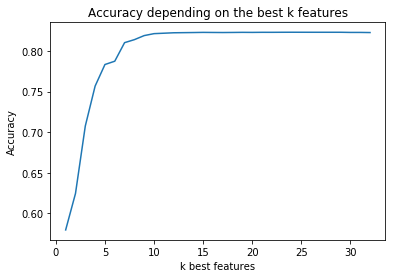

In [49]:
# For every k, show the accuracy when only keeping the k best features
ks = range(1, x.shape[1] + 1)
accuracies = [sub_features[k][1] for k in ks]
plt.plot(ks, accuracies)
plt.xlabel('k best features')
plt.ylabel('Accuracy')
plt.title('Accuracy depending on the best k features')
plt.show()

In [53]:
ks = [1, 5, 10, 15, 20, 25, 30]
for k in ks:
    print('\033[1m' + str(k) + "th best features : \033[0m")
    print(sub_features[k][0])
    print("Accuracy : \033[91m" + str(sub_features[k][1]) + '\033[0m\n')

1th best features : 
['sex_upon_outcome_Intact Male']
Accuracy : 0.5797599435161215

5th best features : 
['sex_upon_intake_Neutered Male' 'sex_upon_intake_Spayed Female'
 'sex_upon_outcome_Intact Female' 'sex_upon_outcome_Intact Male'
 'sex_upon_outcome_Unknown']
Accuracy : 0.7833843257236996

10th best features : 
['intake_year' 'age_upon_intake_(years)' 'time_in_shelter_days'
 'intake_type_Public Assist' 'intake_type_Stray'
 'sex_upon_intake_Neutered Male' 'sex_upon_intake_Spayed Female'
 'sex_upon_outcome_Intact Female' 'sex_upon_outcome_Intact Male'
 'sex_upon_outcome_Unknown']
Accuracy : 0.8213854240213385

15th best features : 
['intake_year' 'intake_number' 'age_upon_intake_(years)'
 'time_in_shelter_days' 'intake_condition_Feral'
 'intake_condition_Injured' 'intake_condition_Sick'
 'intake_type_Euthanasia Request' 'intake_type_Public Assist'
 'intake_type_Stray' 'sex_upon_intake_Neutered Male'
 'sex_upon_intake_Spayed Female' 'sex_upon_outcome_Intact Female'
 'sex_upon_outcome

Among the proposed k's, the best one seems to be k=25, with an accuracy of 0.8231. However, if we look at the best altogether k, it is better with only k=21. and an accuracy of 0.82303. **//TODO analysis about the features**

___
**D)** Train a random forest. Use 5-fold cross-validation on the training set to fine-tune the parameters of the classifier using a grid search on the number of estimators "n_estimators" and the max depth of the trees "max_depth". For the chosen parameters, estimate the performance of your classifier on the test set by presenting the confusion matrix, accuracy, precision, recall, and F1-score with respect to both classes and compare the performance with the performance of the logistic regression. Interpret the results.

In [54]:
def find_hyperparameters_for_random_forest(x, y, min_n_estimators, max_n_estimators, min_depth, max_depth, n_folds = 5):
    """
    Find the best hyperparameters for a random forest classifier
    
    Parameters
    ----------
    x : DataFrame = The input data
    y : Series = The output values
    min_n_estimators : int = the smallest number that will be tried for the n_estimators hyperparameter
    max_n_estimators : int = the biggest  number that will be tried for the n_estimators hyperparameter
    min_depth : int = the smallest depth that will be tried for the depth hyperparameter
    max_depth : int = the biggest  depth that will be tried for the depth hyperparameter
    n_folds : int = number of folds for the cross-validation (default: 5)
    
    Returns
    ---------
    The best depth, the best number of estimators, and the best accuracy
    
    """
    
    best_depth = -1
    best_estimators = -1
    best_accuracy = -1
    folds = build_k_indices(y, n_folds)
    # Double loop corresponding top the grid search for the best hyperparameters
    for depth in range(min_depth, max_depth + 1):
        for n_estimators in range(min_n_estimators, max_n_estimators + 1):
            # Create the RandomForestClassifier and use our cross_validate_compute_accuracy function to get the accuracy
            # of the classifier with the current hyperparameters
            classifier = RandomForestClassifier(n_estimators = n_estimators, max_depth = depth)
            accuracy = cross_validate_compute_accuracy(folds, x, y, classifier)
            # Update the best accuaryc and hyperparameters if better
            if(accuracy > best_accuracy):
                best_depth = depth
                best_estimators = n_estimators
                best_accuracy = accuracy
                
    print("Final results: best depth is "+str(best_depth)+", best number of estimators is "+str(best_estimators)+" that give an accuracy of "+str(best_accuracy))
    return best_depth, best_estimators, best_accuracy

In [55]:
best_depth, best_estimators, _ = find_hyperparameters_for_random_forest(train_x, train_y, 10, 20, 15, 25)

Final results: best depth is 15, best number of estimators is 18 that give an accuracy of 0.8556366203812662


In [56]:
# Now that we have the best hyperparamters, we can train our classifier, and make a prediction
classifier = RandomForestClassifier(n_estimators = best_estimators,max_depth = best_depth)
classifier.fit(train_x, train_y)
prediction = classifier.predict(test_x)

In [57]:
# Get the metrics
conf_matrix = create_confusion_matrix(prediction, test_y)
metrics = get_metrics(conf_matrix, show=True)

Accuracy : 0.8498179992468934
Precision wrt Positive class : 0.7869214768590743
Precision wrt Negative class : 0.9085173501577287
Recall wrt Positive class : 0.8892316732775084
Recall wrt Negative class : 0.8204229210036157
F1 wrt Positive class : 0.834954134767915
F1 wrt Negative class : 0.8622258045943924


\# TODO comments